**Combining USGS (flow) and Daymet (prcp) data & Analysis**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from simpledbf import Dbf5
from dataretrieval import nwis

In [2]:
# load in precip data
daymet = pd.read_csv("daymet_gages_precip.csv", dtype={'site_id': str})
# Slice the DataFrame from that index onward
daymet = daymet.loc[daymet['year']>=2013,:]
daymet

,year,yday,prcp (mm/day),lat,lon,site_id
12045,2013.0,1.0,0.00,41.658983,-73.528458,01200000
12046,2013.0,2.0,0.00,41.658983,-73.528458,01200000
12047,2013.0,3.0,0.00,41.658983,-73.528458,01200000
12048,2013.0,4.0,0.00,41.658983,-73.528458,01200000
12049,2013.0,5.0,0.00,41.658983,-73.528458,01200000
...,...,...,...,...,...,...
2328695,2023.0,361.0,6.19,43.463959,-73.284276,04280450
2328696,2023.0,362.0,2.43,43.463959,-73.284276,04280450
2328697,2023.0,363.0,5.67,43.463959,-73.284276,04280450
2328698,2023.0,364.0,1.37,43.463959,-73.284276,04280450


In [3]:
# Check for duplicates based on site_id, year, and yday
duplicates = daymet[daymet.duplicated(subset=["site_id", "year", "yday"], keep=False)]
duplicates

,year,yday,prcp (mm/day),lat,lon,site_id


Create date-time vectors/ data frames to align with the daymet df (will do the same for usgs using datetime_all after loading in the usgs data)

In [4]:
# Generate a date range from 2013-01-01 to 2023-12-31
datetime_vector = pd.date_range(start="2013-01-01", end="2023-12-31", freq="D")

# Remove December 31st for leap years
datetime_vector1 = datetime_vector[~((datetime_vector.month == 12) & (datetime_vector.day == 31) & datetime_vector.is_leap_year)]

# Convert to DataFrame
datetime_no31st = pd.DataFrame({'datetime': datetime_vector1}) #includes leap years, doesn't include 12/31 of leap years
#print(datetime.iloc[0:1500,:])
print(datetime_no31st.size)
datetime_all = pd.DataFrame({'datetime': datetime_vector})
print(datetime_all.size)

4015
4017


In [5]:
datetime_no31st

,datetime
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
4010,2023-12-27
4011,2023-12-28
4012,2023-12-29
4013,2023-12-30


In [6]:
# For Daymet; has leap years, doesn't include 12/31 of leap years
#  Extract year and yday (day of the year)
datetime_no31st['year'] = datetime_no31st['datetime'].dt.year
datetime_no31st['yday'] = datetime_no31st['datetime'].dt.dayofyear

# Merge with daymet on year and yday
daymet = daymet.merge(datetime_no31st[['year', 'yday', 'datetime']], on=['year', 'yday'], how='left')
daymet

,year,yday,prcp (mm/day),lat,lon,site_id,datetime
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05
...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30


In [7]:
num_unique_sites1 = daymet["site_id"].nunique()
print(f"Number of unique site_id values: {num_unique_sites1}")

Number of unique site_id values: 145


Using streamstats to get usgs flow data: I slightly modified the code from the "Batch_Precip_Flow" file to add the date of the data as some sites don't have daily until later years

In [8]:
# Read in GagesII and make STAID into a str so it keeps the 0 in front of every number
gages_df = pd.read_csv('NYS_Gage_LatLong.csv', dtype={'STAID': str})
gages_df['STAID'] = gages_df['STAID'].astype(str)
# read in the wetland data from ArcGIS & flow data csv
flow = pd.read_csv('nys_gauge_mmd.csv', dtype={'STAID': str})
flow['STAID'] = flow['STAID'].astype(str) # keeps the 0 in front of the GAGE_ID
dbf = Dbf5('TabulateInter_Emergent1.dbf')
emergent = dbf.to_dataframe() # converts dbf to a dataframe
dbf1 = Dbf5('TabulateInter_ForestShrub1.dbf')
forest_shrub = dbf1.to_dataframe()
dbf2 = Dbf5('TabulateInter_FreshWPond1.dbf')
pond = dbf2.to_dataframe()
# 'Lake' and 'other' also exist but were removed because they have fewer than 150 gauge locations
# Identify the 149 common GAGE_IDs in pond, emergent, and forest_shrub
common_gage_ids = set(pond['GAGE_ID']).intersection(emergent['GAGE_ID'], forest_shrub['GAGE_ID'])
# Filter flow to match the 149 common GAGE_IDs
flow_cleaned = flow[flow['STAID'].isin(common_gage_ids)].reset_index(drop=True)

# Shorten 'gages_df' to have the same amount of rows aligning with the 'STAID' column of 'flow_cleaned'
gages_df = gages_df[gages_df['STAID'].isin(flow_cleaned['STAID'])]

results = []

for i in range(len(gages_df)):
    try:
        # Use USGS site ID directly from gages_df
        #site_id = str(int(gages_df['STAID'].iloc[i]))  # Convert to string properly
        #site_id = str(gages_df['STAID'].iloc[i]).zfill(8)  # Ensures 8-digit format
        site_id = gages_df['STAID'].iloc[i]


        # Retrieve daily mean flow data (00060)
        get_flow = nwis.get_record(sites=site_id, service='dv', parameterCd='00060', start='2013-01-01')

        if get_flow.empty:
            print(f"No daily flow data for site {site_id}. Skipping.")
            continue  # Skip this site if no data is found

        # Find correct column for '00060'
        column_name = [col for col in get_flow.columns if '00060' in col]
        daily_flow_series = get_flow[column_name[0]] if column_name else pd.Series(dtype='float64')

        # Get drainage area
        cur_drainage_area = gages_df.loc[gages_df['STAID'] == site_id, 'DRAIN_SQKM']
        if cur_drainage_area.isna().any() or cur_drainage_area.empty:
            print(f"Skipping site {site_id}: Missing drainage area.")
            continue  # Skip if no valid drainage area
        
        cur_drainage_area = cur_drainage_area.iloc[0]
        normalized_flow_series = daily_flow_series / cur_drainage_area if cur_drainage_area > 0 else np.nan

        # **Store dates from get_flow.index**
        date_series = [dt.strftime('%Y-%m-%d') for dt in get_flow.index]


        # Store results
        results.append({
            'STAID': site_id,
            'daily_flow': daily_flow_series.tolist(),  
            'normalized_daily_flow': normalized_flow_series.tolist(),
            'datetime': date_series  # Add date list for each station
            
        })

    except Exception as e:
        print(f"Error at site {site_id}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

No daily flow data for site 01301000. Skipping.
No daily flow data for site 01317000. Skipping.
No daily flow data for site 01372058. Skipping.
No daily flow data for site 01376500. Skipping.
        STAID                                         daily_flow  \
0    01200000  [408.0, 376.0, 345.0, 338.0, 331.0, 317.0, 307...   
1    01302020  [44.7, 40.9, 39.2, 35.8, 33.9, 32.9, 31.7, 30....   
2    01312000  [247.0, 225.0, 209.0, 204.0, 199.0, 192.0, 187...   
3    01315000  [330.0, 330.0, 330.0, 329.0, 327.0, 327.0, 327...   
4    01315500  [1140.0, 1030.0, 990.0, 1110.0, 1090.0, 1100.0...   
..        ...                                                ...   
140  04275000  [275.0, 1380.0, 1980.0, 911.0, 629.0, 494.0, 4...   
141  04275500  [350.0, 318.0, 300.0, 286.0, 272.0, 259.0, 245...   
142  04276500  [197.0, 184.0, 182.0, 171.0, 168.0, 162.0, 157...   
143  04279000  [223.0, 286.0, 283.0, 288.0, 290.0, 295.0, 298...   
144  04280450  [220.0, 185.0, 190.0, 221.0, 195.0, 184.0, 17

In [67]:
# Create a new column that stores the length of each list in results_df
results_df1 = results_df.copy()
results_df1["flow_length"] = results_df["daily_flow"].apply(lambda x: len(x) if isinstance(x, list) else 0)
results_df1["normalized_flow_length"] = results_df["normalized_daily_flow"].apply(lambda x: len(x) if isinstance(x, list) else 0)
results_df1["datetime_length"] = results_df["datetime"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Check if any of the lengths are different
results_df1["length_match"] = (results_df1["flow_length"] == results_df1["normalized_flow_length"]) & (results_df1["flow_length"] == results_df1["datetime_length"])

# Find rows where the lengths do not match
mismatched_lengths = results_df1[~results_df1["length_match"]]
mismatched_lengths


,STAID,daily_flow,normalized_daily_flow,datetime,flow_length,normalized_flow_length,datetime_length,length_match


In [68]:
results_df

,STAID,daily_flow,normalized_daily_flow,datetime
0,01200000,"[408.0, 376.0, 345.0, 338.0, 331.0, 317.0, 307...","[0.7660750426833356, 0.7059907256101329, 0.647...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
1,01302020,"[44.7, 40.9, 39.2, 35.8, 33.9, 32.9, 31.7, 30....","[0.44001866387889743, 0.4026121555401992, 0.38...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
2,01312000,"[247.0, 225.0, 209.0, 204.0, 199.0, 192.0, 187...","[0.495765619677921, 0.4516083580062033, 0.4194...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
3,01315000,"[330.0, 330.0, 330.0, 329.0, 327.0, 327.0, 327...","[0.9777047758211832, 0.9777047758211832, 0.977...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
4,01315500,"[1140.0, 1030.0, 990.0, 1110.0, 1090.0, 1100.0...","[0.5537859772646568, 0.5003504882303478, 0.480...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
...,...,...,...,...
140,04275000,"[275.0, 1380.0, 1980.0, 911.0, 629.0, 494.0, 4...","[0.536265594603491, 2.6910782565557003, 3.8611...","[2016-03-09, 2016-03-10, 2016-03-11, 2016-03-1..."
141,04275500,"[350.0, 318.0, 300.0, 286.0, 272.0, 259.0, 245...","[0.30386217506281266, 0.2760804904856412, 0.26...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
142,04276500,"[197.0, 184.0, 182.0, 171.0, 168.0, 162.0, 157...","[0.2837274119854524, 0.26500428327575254, 0.26...","[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0..."
143,04279000,"[223.0, 286.0, 283.0, 288.0, 290.0, 295.0, 298...","[0.3324787288160358, 0.42640769704657505, 0.42...","[2018-04-26, 2018-04-27, 2018-04-28, 2018-04-2..."


Turn the flow dataset from row based lists to columns

In [10]:
# Define the full date range for all sites (2013-01-01 to 2023-12-31)
full_date_range = pd.date_range(start="2013-01-01", end="2023-12-31", freq="D")

# Create an empty list to store reshaped data
long_format_data = []

# Iterate over each row in results_df
for _, row in results_df.iterrows():
    site_id = row["STAID"]
    daily_flow_list = row["daily_flow"]
    normalized_flow_list = row["normalized_daily_flow"]
    datetime_list = row["datetime"]

    # Skip rows where any list is missing
    if not isinstance(daily_flow_list, list) or not isinstance(normalized_flow_list, list) or not isinstance(datetime_list, list):
        print(f"Skipping {site_id}: Missing data")
        continue

    # Convert datetime_list to pandas DatetimeIndex for alignment
    site_dates = pd.to_datetime(datetime_list)

    # Create a DataFrame with available flow data
    temp_df = pd.DataFrame({
        "datetime": site_dates,
        "flow": daily_flow_list,
        "normalized_flow": normalized_flow_list
    })

    # Ensure site_id is included
    temp_df["site_id"] = site_id

    # Reindex to match full date range, inserting NaNs where missing
    temp_df = temp_df.set_index("datetime").reindex(full_date_range).reset_index()
    temp_df.rename(columns={"index": "datetime"}, inplace=True)

    # Fill site_id for all rows (since it was lost during reindexing)
    temp_df["site_id"] = site_id

    # Append to list
    long_format_data.append(temp_df)

# Combine all individual site DataFrames
results_long = pd.concat(long_format_data, ignore_index=True)

# Convert site_id to string
results_long["site_id"] = results_long["site_id"].astype(str)

# Extract year and yday to match daymet
results_long["year"] = results_long["datetime"].dt.year
results_long["yday"] = results_long["datetime"].dt.dayofyear

# Rearrange columns to match daymet structure
results_long = results_long[["site_id", "year", "yday", "datetime", "flow", "normalized_flow"]]
print(results_long)

         site_id  year  yday   datetime   flow  normalized_flow
0       01200000  2013     1 2013-01-01  408.0         0.766075
1       01200000  2013     2 2013-01-02  376.0         0.705991
2       01200000  2013     3 2013-01-03  345.0         0.647784
3       01200000  2013     4 2013-01-04  338.0         0.634641
4       01200000  2013     5 2013-01-05  331.0         0.621497
...          ...   ...   ...        ...    ...              ...
582460  04280450  2023   361 2023-12-27  543.0         1.246469
582461  04280450  2023   362 2023-12-28  550.0         1.262538
582462  04280450  2023   363 2023-12-29  508.0         1.166126
582463  04280450  2023   364 2023-12-30  640.0         1.469135
582464  04280450  2023   365 2023-12-31  578.0         1.326812

[582465 rows x 6 columns]


Data from USGS and Daymet do different things with leap years- USGS has (145x2=290) extra rows of data, so when merging the datasets, do not include 12/31 for leap years from usgs so the 2 dataframes align correctly

Both data frames have the same # of unique site IDs but not days. USGS has 2 extra days for each site: (dec 31st 2016, 2020)

In [11]:
# Merge results_long into daymet, aligning by site_id and datetime
daymet_usgs = daymet.merge(results_long[["site_id", "datetime", "flow", "normalized_flow"]],
                              on=["site_id", "datetime"], how="left")
daymet_usgs

,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01,408.0,0.766075
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02,376.0,0.705991
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03,345.0,0.647784
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04,338.0,0.634641
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05,331.0,0.621497
...,...,...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27,543.0,1.246469
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28,550.0,1.262538
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29,508.0,1.166126
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30,640.0,1.469135


## Ratio of flow to precip

In [ ]:
# change units of normalized_flow from cfs/sqkm to mm/day
daymet_usgs['normalized_flow'] = daymet_usgs['normalized_flow'] * 2.44658
# Compute the ratio of normalized flow to precipitation
daymet_usgs['flow_precip_ratio'] = daymet_usgs['normalized_flow'] / daymet_usgs['prcp (mm/day)']
daymet_usgs

,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01,408.0,4.585537,inf
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02,376.0,4.225887,inf
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03,345.0,3.877476,inf
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04,338.0,3.798802,inf
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05,331.0,3.720129,inf
...,...,...,...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27,543.0,7.461056,1.205340
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28,550.0,7.557239,3.109975
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29,508.0,6.980141,1.231065
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30,640.0,8.793878,6.418889


In [13]:
# Export df to a .csv
daymet_usgs.to_csv("daily_flow_precip_2013_2024.csv", index=False)

In [14]:
# Replace missing data (-99999) with 0 - this also gets rid of a line in the graph below
daymet_usgs["flow"] = daymet_usgs["flow"].apply(lambda x: max(x, 0)) 
daymet_usgs["normalized_flow"] = daymet_usgs["normalized_flow"].apply(lambda x: max(x, 0))

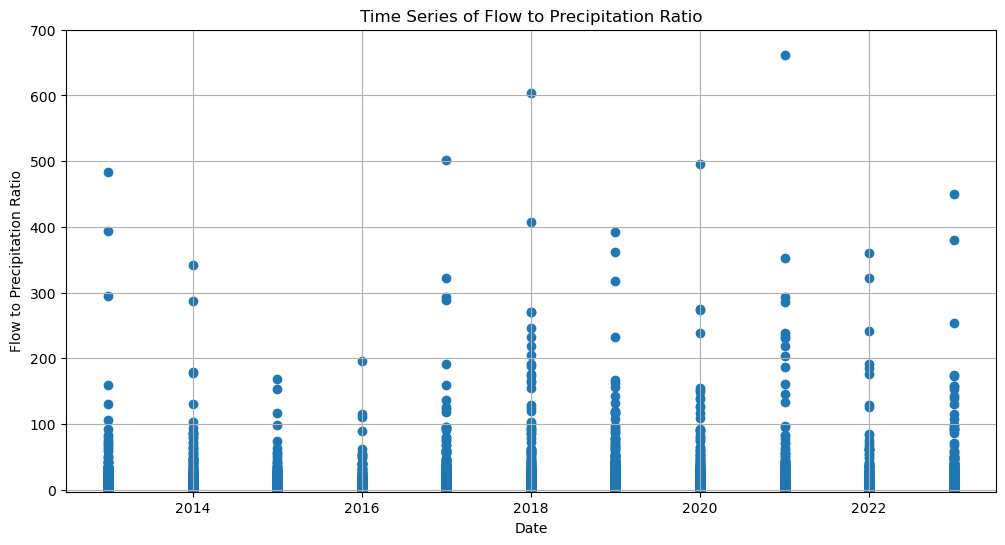

In [20]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.scatter(daymet_usgs['year'], daymet_usgs['flow_precip_ratio'])
plt.xlabel("Date")
plt.ylabel("Flow to Precipitation Ratio")
plt.title("Time Series of Flow to Precipitation Ratio")
plt.grid(True)
plt.ylim([-3, 700])
plt.show()